In [40]:
# imports required to run the code.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import sklearn
import autograd.numpy as np_
import numpy as np
from autograd import grad

In [41]:
# preparing dataset.

dfo = pd.read_csv('healthcare-dataset-stroke-data.csv')
dfo = dfo.fillna(0)

# ---------------------------------------- #

dfo.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [42]:
# preparing dataset.

dfo = pd.read_csv('healthcare-dataset-stroke-data.csv')
dfo = dfo.fillna(0)

dfo = dfo.sort_values(by=['bmi'], ascending=True)
dfo = dfo.reset_index(drop = True)

# ---------------------------------------- #

df = pd.get_dummies(dfo) # converte dados não numéricos.
df = df.drop(columns=['gender_Other', 'gender_Male']) # remoção de dados redundantes.
df.rename(columns={"gender_Female": "gender"}, inplace = True)

# ---------------------------------------- #
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,34248,50.0,1,0,81.96,0.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,29224,30.0,0,0,91.23,0.0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,49894,78.0,1,1,206.53,0.0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,37526,68.0,1,1,233.30,0.0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
4,29095,71.0,1,0,93.60,0.0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0


In [43]:
# ----------------- #

filtery = (df['stroke'] == 0)
dfo1 = df[filtery]

dfo1 = dfo1.iloc[:300]

# ----------------- #

filtery = (df['stroke'] == 1)
dfo2 = df[filtery]

dfo = dfo1.append(dfo2)

dfo

C:\Users\pache\AppData\Local\Temp\ipykernel_2200\401889612.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfo = dfo1.append(dfo2)


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,34248,50.0,1,0,81.96,0.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,29224,30.0,0,0,91.23,0.0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,49894,78.0,1,1,206.53,0.0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,37526,68.0,1,1,233.30,0.0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
4,29095,71.0,1,0,93.60,0.0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,42117,43.0,0,0,143.43,45.9,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
4977,24905,65.0,0,0,205.77,46.0,1,1,0,1,...,0,1,0,0,0,1,0,1,0,0
4999,17004,70.0,0,0,221.58,47.5,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
5018,13861,52.0,1,0,233.29,48.9,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0


In [44]:
dfa = dfo.drop(columns=['stroke','id','ever_married_No','Residence_type_Rural','smoking_status_formerly smoked']).astype(float)

X_train, X_test, y_train, y_test = train_test_split(dfa, dfo['stroke'], train_size=0.5)
y_train = y_train.replace(to_replace=0,value=-1)
y_test = y_test.replace(to_replace=0,value=-1)
y_train.value_counts()

-1    153
 1    121
Name: stroke, dtype: int64

In [45]:
X_train,X_test,y_train,y_test = X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy()

In [46]:
import autograd.numpy as np_
import numpy as np
from autograd import grad

# ---------------------------------------- #

def predict( w, b, pontos ):
    est = w.T @ pontos + b
    return est


def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

def loss( parametros ):
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)
    return mse

# ---------------------------------------- #

In [49]:
results = []
for _ in range(10):
    g = grad(loss)

    pontos = X_train.T
    alvos = (y_train).astype(float)

    w = np.random.randn( pontos.shape[0],1)
    b = 0.0
    alpha = 0.000001

    for n in range(1000):
        grad_ = g( (w, b, pontos, alvos) )
        w -= alpha*grad_[0]
        b -= alpha*grad_[1]

    y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

    results.append(accuracy(y_test, y_pred))

In [50]:
print(np.array(results).mean())
print(np.array(results).std())

0.4556363636363637
0.21996874308383974


In [52]:
g = grad(loss)

pontos = X_train.T
alvos = (y_train).astype(float)

w = np.random.randn( pontos.shape[0],1)
b = 0.0
alpha = 0.000001
print(w)
for n in range(1000):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

[[ 0.6339335 ]
 [-0.71070576]
 [-0.20895122]
 [ 1.53417011]
 [ 0.42345391]
 [-0.96586912]
 [-0.20059494]
 [ 0.95235796]
 [ 0.75583683]
 [ 0.97208457]
 [-0.02437396]
 [ 0.83650021]
 [ 1.08936165]
 [ 0.17741149]
 [ 0.79422981]
 [ 1.6242944 ]]


In [53]:
from collections import OrderedDict

columns = list(dfa.columns)
res = {columns[i]: float(w[i]) for i in range(len(w))}
sorted(res.items(), key=lambda t: t[1], reverse=True)

[('smoking_status_smokes', 1.6219964238682831),
 ('Residence_type_Urban', 1.08226700119213),
 ('work_type_Private', 0.9664851188545849),
 ('work_type_Govt_job', 0.950681656360524),
 ('work_type_children', 0.8335873742953622),
 ('smoking_status_never smoked', 0.7907138745652197),
 ('work_type_Never_worked', 0.7557896558786737),
 ('smoking_status_Unknown', 0.17341101227982025),
 ('bmi', 0.16644984996769205),
 ('age', 0.008650252193572787),
 ('work_type_Self-employed', -0.026463017926963463),
 ('avg_glucose_level', -0.0287536890271067),
 ('ever_married_Yes', -0.20888076476519485),
 ('heart_disease', -0.2111834308937052),
 ('hypertension', -0.713351003180279),
 ('gender', -0.971994451735166)]

[('smoking_status_never smoked', 1.9662127728927499),
 ('work_type_Govt_job', 1.5288039518764849),
 ('heart_disease', 1.3447350243293723),
 ('work_type_Private', 0.7072463824185442),
 ('ever_married_Yes', 0.4894299210636069),
 ('hypertension', 0.26751445224545006),
 ('work_type_children', 0.11226938267801652),
 ('bmi', 0.028330032893819176),
 ('gender', 0.0008012721255334959),
 ('avg_glucose_level', -0.0048443433053298015),
 ('age', -0.007321216850998305),
 ('smoking_status_smokes', -0.6108328187336413),
 ('Residence_type_Urban', -0.6731651799177507),
 ('smoking_status_Unknown', -0.7852556759763394),
 ('work_type_Never_worked', -1.1298236983714267),
 ('work_type_Self-employed', -1.7866693388941148)]

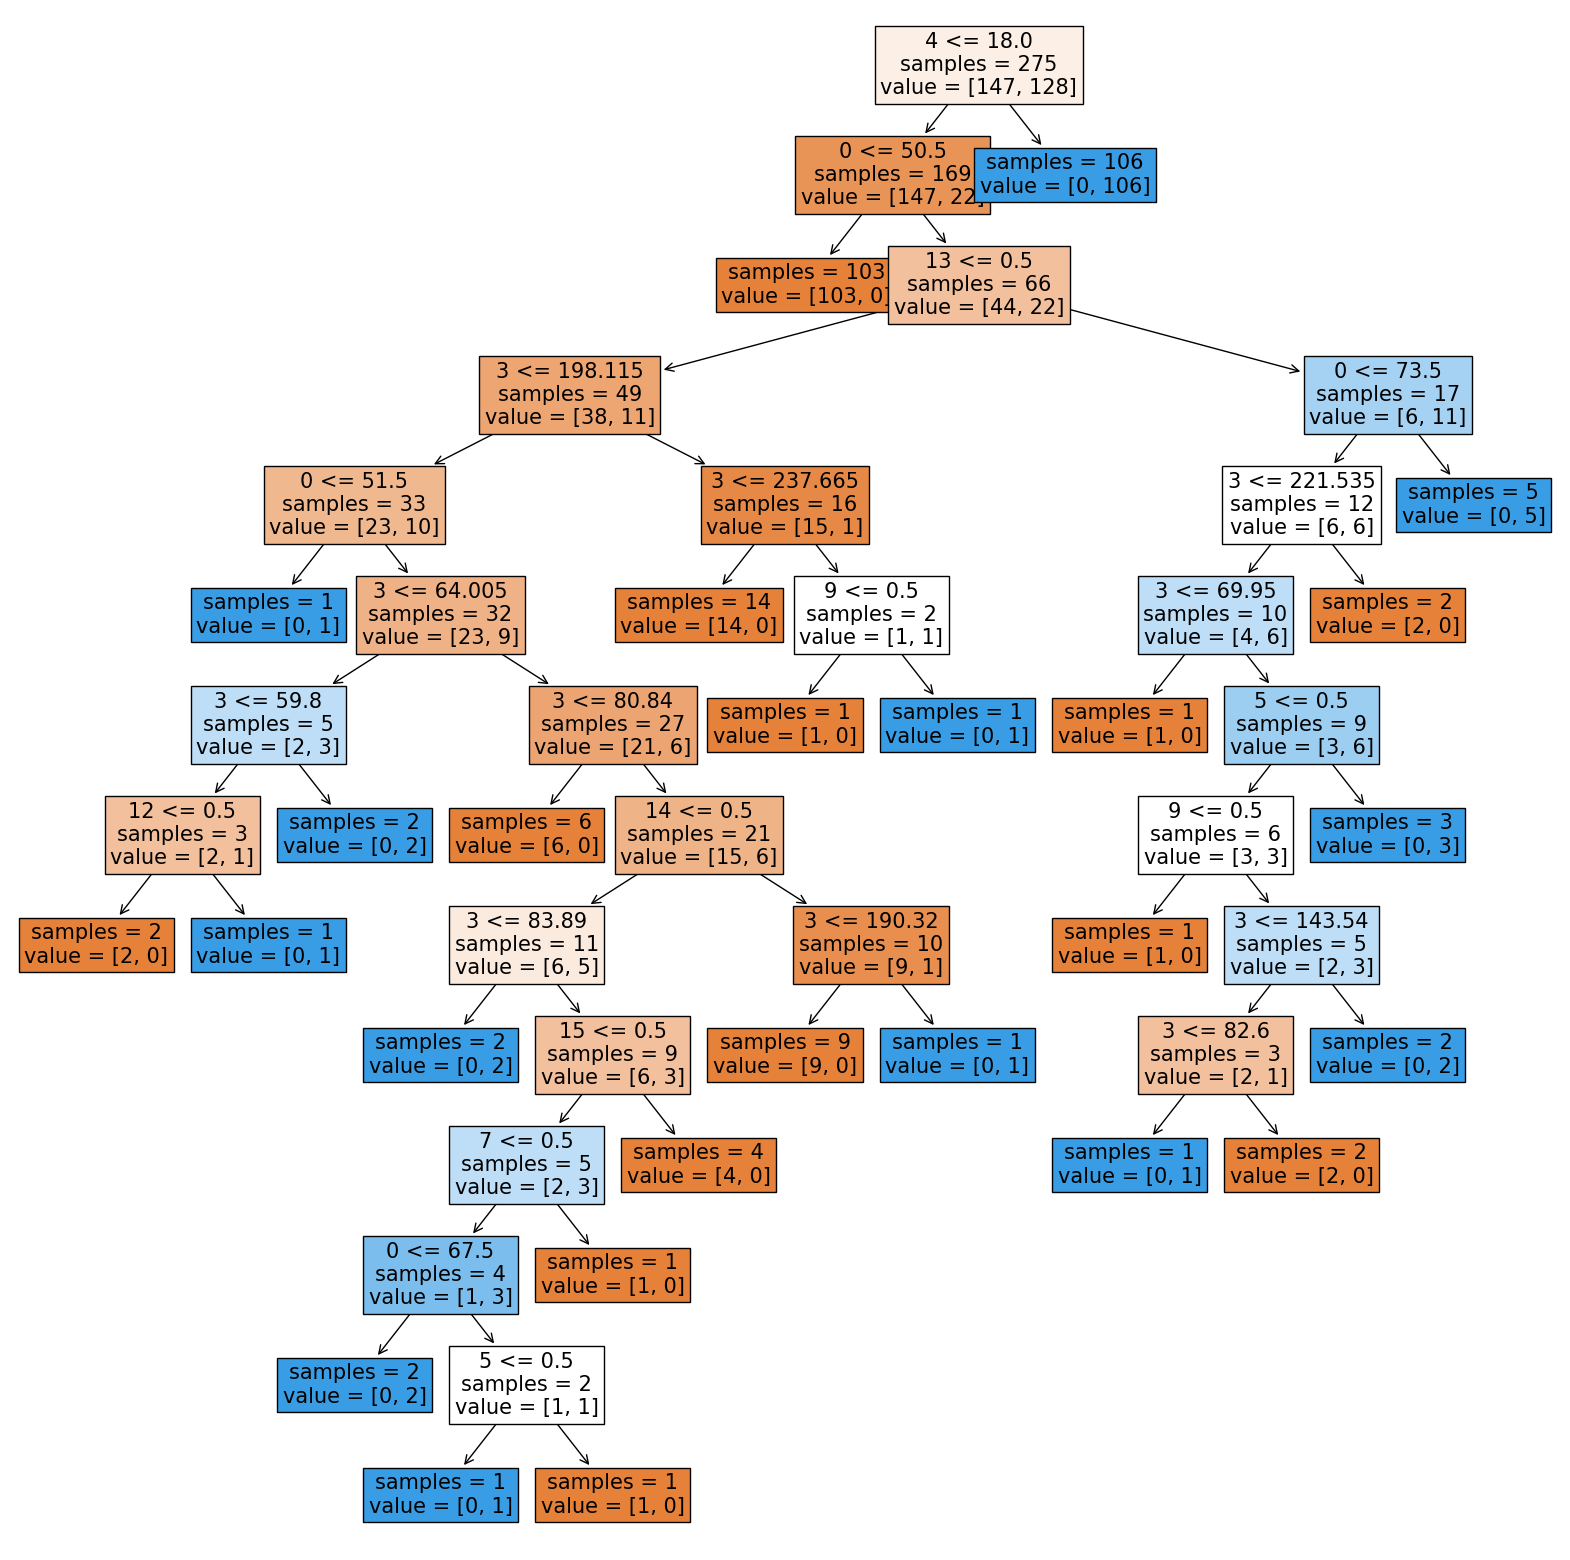

In [62]:
from sklearn.tree import DecisionTreeClassifier

df_features = pd.DataFrame(X_test)
df_rotulo = pd.DataFrame(y_test)
tree = DecisionTreeClassifier(criterion='entropy')

# Agora, vamos usar o método .fit() para ajustar os parâmetros da árvore:
tree.fit(df_features, df_rotulo)

# Podemos visualizar a árvore de decisão em uma figura!
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=df_features.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)
